In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import zipfile
import os

uploaded_filename = list(uploaded.keys())[0]

# Unzip
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/signature_data")

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
import pandas as pd

csv_path = "/content/signature_data/sign_data/sign_data"

train_df = pd.read_csv(f"{csv_path}/train_data.csv", header=None)
test_df = pd.read_csv(f"{csv_path}/test_data.csv", header=None)

train_df.columns = ['img1', 'img2', 'label']
test_df.columns = ['img1', 'img2', 'label']


In [ ]:
import pandas as pd
import os
from PIL import Image
import numpy as np

# Paths
csv_path = "/content/signature_data/sign_data/sign_data"
train_img_path = "/content/signature_data/sign_data/sign_data/train"
test_img_path = "/content/signature_data/sign_data/sign_data/test"

train_df = pd.read_csv(f"{csv_path}/train_data.csv", header=None)
test_df  = pd.read_csv(f"{csv_path}/test_data.csv", header=None)


train_df.columns = ['img1', 'img2', 'label']
test_df.columns = ['img1', 'img2', 'label']


train_subset = train_df.sample(n=5000, random_state=42)


def load_image(path):
    img = Image.open(path).convert("L").resize((128, 128))
    img = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, axis=-1)
    return img


X1_train, X2_train, y_train = [], [], []

for _, row in train_subset.iterrows():
    img1_path = os.path.join(train_img_path, row['img1'])
    img2_path = os.path.join(train_img_path, row['img2'])

    if os.path.exists(img1_path) and os.path.exists(img2_path):
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)
        X1_train.append(img1)
        X2_train.append(img2)
        y_train.append(row['label'])
    else:
        print(f"Skipped: {img1_path} or {img2_path} not found.")

X1_test, X2_test, y_test = [], [], []

for _, row in test_df.iterrows():
    img1_path = os.path.join(test_img_path, row['img1'])
    img2_path = os.path.join(test_img_path, row['img2'])

    if os.path.exists(img1_path) and os.path.exists(img2_path):
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)
        X1_test.append(img1)
        X2_test.append(img2)
        y_test.append(row['label'])
    else:
        print(f"Skipped: {img1_path} or {img2_path} not found.")


X1_train = np.array(X1_train, dtype=np.float32)
X2_train = np.array(X2_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X1_test = np.array(X1_test, dtype=np.float32)
X2_test = np.array(X2_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


print(f"\n Loaded {len(X1_train)} training samples and {len(X1_test)} testing samples!")



 Loaded 5000 training samples and 5748 testing samples!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_base_cnn(input_shape):
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
    ])
    return model

input_shape = (128, 128, 1)
base_cnn = build_base_cnn(input_shape)

input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

feat_a = base_cnn(input_a)
feat_b = base_cnn(input_b)

l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feat_a, feat_b])
output = layers.Dense(1, activation='sigmoid')(l1_distance)

siamese_model = Model(inputs=[input_a, input_b], outputs=output)

siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Siamese model built and compiled!")


Siamese model built and compiled!


In [ ]:
history = siamese_model.fit(
    [X1_train, X2_train],
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=5
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.5638 - loss: 0.5941 - val_accuracy: 0.8930 - val_loss: 0.3065
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9189 - loss: 0.2263 - val_accuracy: 0.9630 - val_loss: 0.1362
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9881 - loss: 0.0538 - val_accuracy: 0.9490 - val_loss: 0.1459
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9863 - loss: 0.0570 - val_accuracy: 0.9600 - val_loss: 0.1530
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9957 - loss: 0.0181 - val_accuracy: 0.9550 - val_loss: 0.1249


In [ ]:
 pip install tensorflow


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


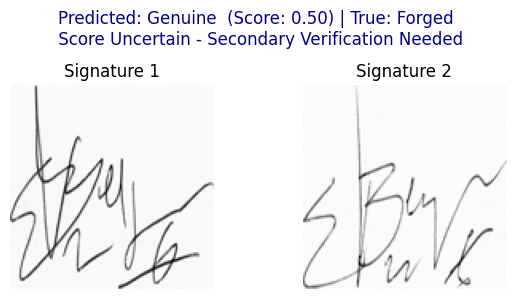

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


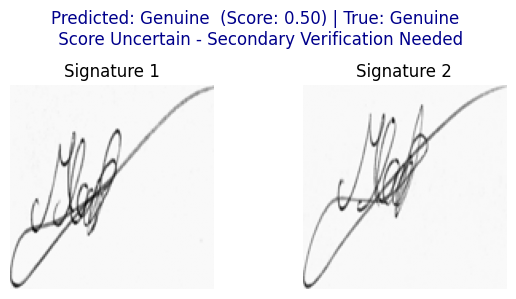

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


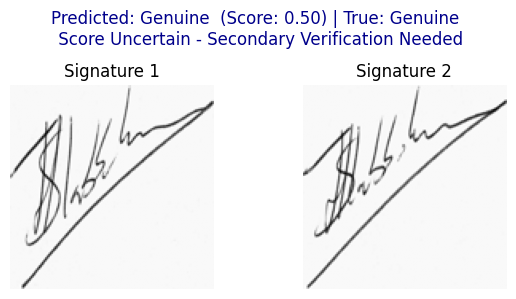

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


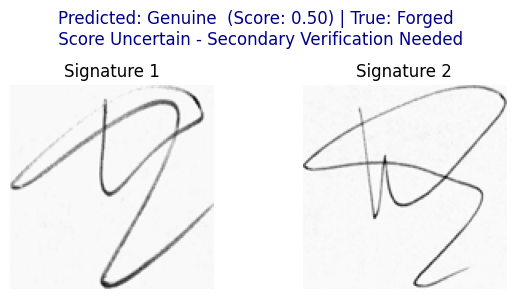

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


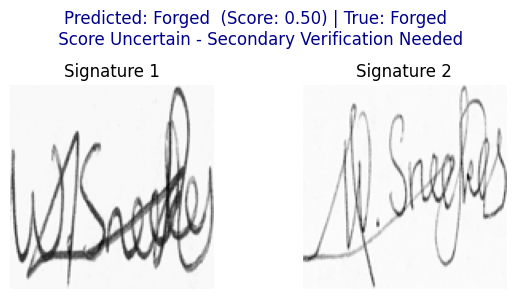

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
import random


lower_thresh = 0.4
upper_thresh = 0.6


num_samples_to_check = 5


sample_indices = random.sample(range(len(X1_test)), num_samples_to_check)

for idx in sample_indices:
    img1 = X1_test[idx].squeeze()
    img2 = X2_test[idx].squeeze()
    true_label = "Genuine " if y_test[idx] == 0 else "Forged "


    img1_input = np.expand_dims(X1_test[idx], axis=0)
    img2_input = np.expand_dims(X2_test[idx], axis=0)


    score = siamese_model.predict([img1_input, img2_input])[0][0]
    pred_label = "Genuine " if score < 0.5 else "Forged "


    if lower_thresh <= score <= upper_thresh:
        verification_required = True
        status = " Score Uncertain - Secondary Verification Needed"
        action_html = """
        <b>Step 2: Manual Verification Triggered</b><br>
        <ul>
        <li> Mobile OTP verification</li>
        <li>Email confirmation request</li>
        <li> User taps Yes or No</li>
        </ul>
        <button style='background-color:lightgreen;padding:8px;margin:5px'>Yes, it's genuine</button>
        <button style='background-color:salmon;padding:8px;margin:5px'>No, it's forged</button>
        """
    else:
        verification_required = False
        status = "Confident Prediction - Auto Verified"
        action_html = ""


    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title("Signature 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title("Signature 2")
    plt.axis('off')

    plt.suptitle(f"Predicted: {pred_label} (Score: {score:.2f}) | True: {true_label}\n{status}", fontsize=12, color="darkblue")
    plt.tight_layout()
    plt.show()

    if verification_required:
        display(HTML(action_html))


In [ ]:

siamese_model.save("siamese_model.h5")
print("Siamese model saved as siamese_model.h5")


Siamese model saved as siamese_model.h5


In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.models import Model

zip_path = "archive.zip"
extract_folder = "signature_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

img1_path = os.path.join("signature_data/sign_data/train/068", os.listdir("signature_data/sign_data/train/068")[0])
img2_path = os.path.join("signature_data/sign_data/train/068_forg", os.listdir("signature_data/sign_data/train/068_forg")[0])


base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
embedding_model = Model(inputs=base_model.input, outputs=x)
embedding_model.trainable = False


def get_embedding(img_path):
    img = load_img(img_path, target_size=(160, 160))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return embedding_model.predict(img, verbose=0)[0]


emb1 = get_embedding(img1_path)
emb2 = get_embedding(img2_path)

diff = np.abs(emb1 - emb2)
similarity = np.linalg.norm(diff)
print(f"Similarity score: {similarity:.4f}")


Similarity score: 25.0194


Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.5631 - loss: 0.5682 - val_accuracy: 0.9100 - val_loss: 0.3047
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9293 - loss: 0.2428 - val_accuracy: 0.9480 - val_loss: 0.1286
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9732 - loss: 0.0929 - val_accuracy: 0.9660 - val_loss: 0.1162
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 490ms/step

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      2772
         1.0       0.97      0.98      0.98      2976

    accuracy                           0.98      5748
   macro avg       0.98      0.98      0.98      5748
weighted avg       0.98      0.98      0.98      5748



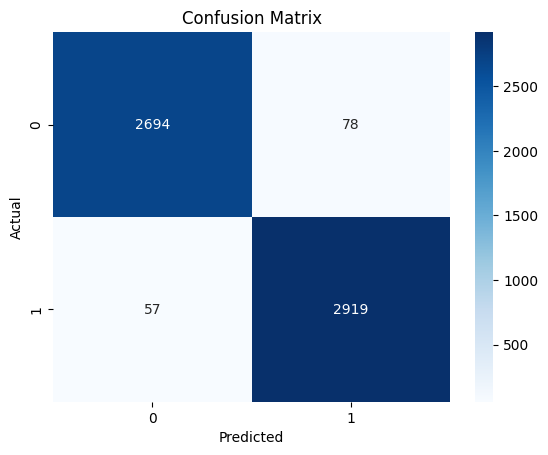

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Subtract, Lambda, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def build_base_cnn(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs, x, name="Base_CNN")


input_1 = Input(shape=(128, 128, 1))
input_2 = Input(shape=(128, 128, 1))

base_cnn = build_base_cnn()

feat1 = base_cnn(input_1)
feat2 = base_cnn(input_2)

diff = Lambda(lambda x: tf.math.abs(x[0] - x[1]))([feat1, feat2])
output = Dense(1, activation='sigmoid')(diff)

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit([X1_train, X2_train], y_train, epochs=3, batch_size=32, validation_split=0.1)

y_pred = (model.predict([X1_test, X2_test]) > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


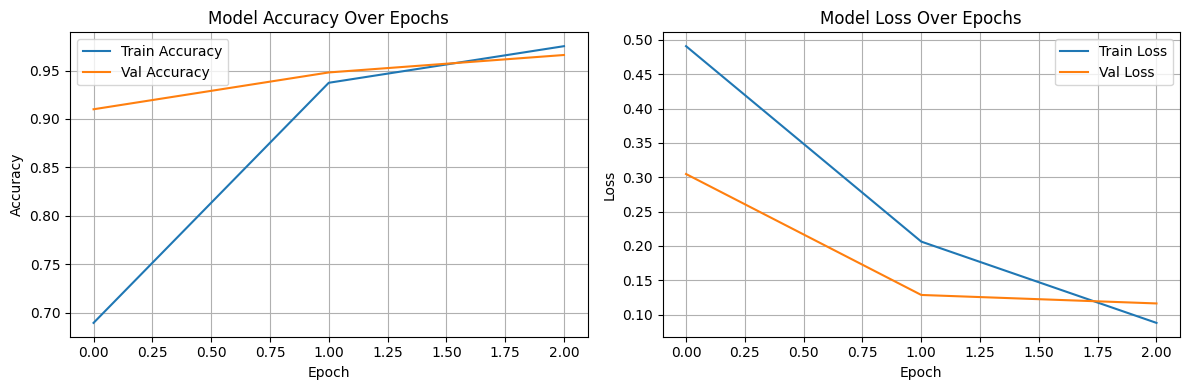

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Logistic Regression Accuracy: 0.9341
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      2772
         1.0       0.95      0.92      0.94      2976

    accuracy                           0.93      5748
   macro avg       0.93      0.93      0.93      5748
weighted avg       0.93      0.93      0.93      5748



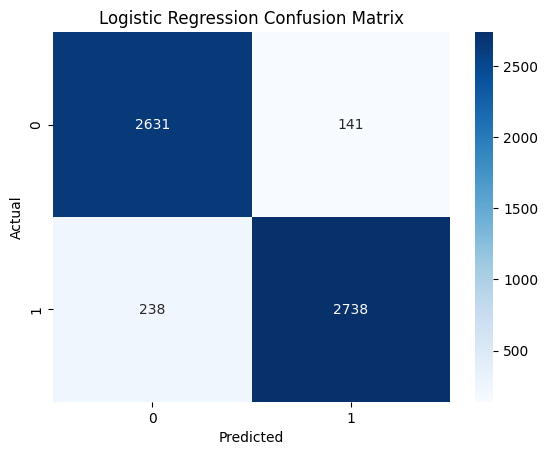

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Combine features (img1, img2, abs diff)
X_train_embed = np.concatenate([X1_train.reshape(len(X1_train), -1),
                                X2_train.reshape(len(X2_train), -1),
                                np.abs(X1_train - X2_train).reshape(len(X1_train), -1)], axis=1)

X_test_embed = np.concatenate([X1_test.reshape(len(X1_test), -1),
                               X2_test.reshape(len(X2_test), -1),
                               np.abs(X1_test - X2_test).reshape(len(X2_test), -1)], axis=1)

# ✅ Step 2: Normalize
scaler = StandardScaler()
X_train_embed = scaler.fit_transform(X_train_embed)
X_test_embed = scaler.transform(X_test_embed)

# ✅ Step 3: Train & evaluate models
def evaluate_model(model, name):
    model.fit(X_train_embed, y_train)
    y_pred = model.predict(X_test_embed)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()




Logistic Regression Accuracy: 0.9341
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      2772
         1.0       0.95      0.92      0.94      2976

    accuracy                           0.93      5748
   macro avg       0.93      0.93      0.93      5748
weighted avg       0.93      0.93      0.93      5748



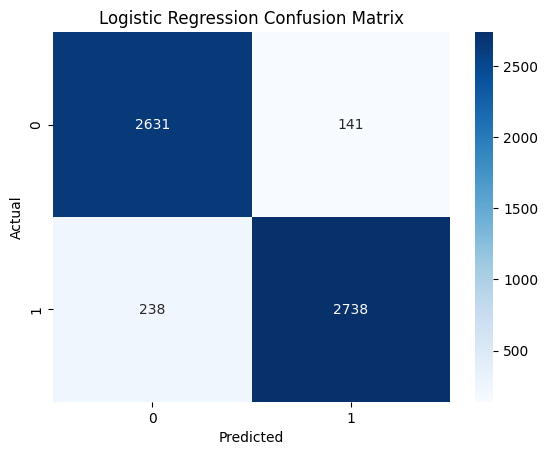


Support Vector Machine Accuracy: 0.9703
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2772
         1.0       0.99      0.96      0.97      2976

    accuracy                           0.97      5748
   macro avg       0.97      0.97      0.97      5748
weighted avg       0.97      0.97      0.97      5748



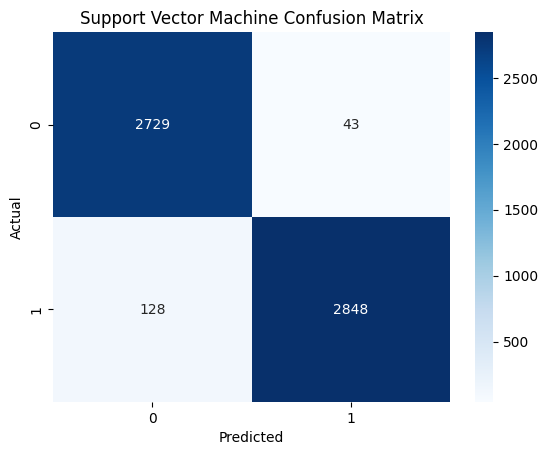

In [ ]:
# ✅ Step 4: Instantiate models with class_weight balanced
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
svm = SVC(kernel='linear', class_weight='balanced')

evaluate_model(logreg, "Logistic Regression")
evaluate_model(svm, "Support Vector Machine")